# Support Vector Machines

## Linear SVM
Let's look at a linear support vector machine applied to the well known Iris dataset

In [1]:
import numpy as np
import os
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['lines.linewidth'] = 2

In [2]:
from sklearn import datasets
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

iris = datasets.load_iris()
X = iris["data"][:,(2,3)] # petal length, petal width
y = (iris["target"] == 2).astype(np.float64) # Iris-Virginica

scaler = StandardScaler()
svm_clf1 = LinearSVC(C=1, loss="hinge")
svm_clf2 = LinearSVC(C=100, loss="hinge")

scaled_svm_clf1 = Pipeline([
    ("std_scaler",scaler),
    ("linear_svc",svm_clf1),
])

scaled_svm_clf2 = Pipeline([
    ("std_scaler",scaler),
    ("linear_svc",svm_clf2),
])

scaled_svm_clf1.fit(X,y)
scaled_svm_clf2.fit(X,y)

Pipeline(memory=None,
     steps=[('std_scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('linear_svc', LinearSVC(C=100, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

In [3]:
#Converting to unscaled parameters
b1 = svm_clf1.decision_function([-scaler.mean_ / scaler.scale_])
b2 = svm_clf2.decision_function([-scaler.mean_ / scaler.scale_])
w1 = svm_clf1.coef_[0] / scaler.scale_
w2 = svm_clf2.coef_[0] / scaler.scale_
svm_clf1.intercept_ = np.array([b1])
svm_clf2.intercept_ = np.array([b2])
svm_clf1.coef_ = np.array([w1])
svm_clf2.coef_ = np.array([w2])

In [4]:
#Finding support vectors
t = y * 2 - 1
support_vectors_idx1 = (t * (X.dot(w1) + b1) < 1).ravel()
support_vectors_idx2 = (t * (X.dot(w2) + b2) < 1).ravel()
svm_clf1.support_vectors_ = X[support_vectors_idx1]
svm_clf2.support_vectors_ = X[support_vectors_idx2]

In [5]:
def plot_svc_decision_boundary(svm_clf, xmin, xmax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    #At the boundary, w0*x0 + w1*x1 + b = 0, so x1 = -w0/w1*x0 - b/w1
    x0 = np.linspace(xmin,xmax,200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    svs = svm_clf.support_vectors_
    plt.scatter(svs[:,0], svs[:,1], s=180, facecolors="red")
    plt.plot(x0, decision_boundary, "k-")
    plt.plot(x0, gutter_up, "k--")
    plt.plot(x0, gutter_down, "k--")

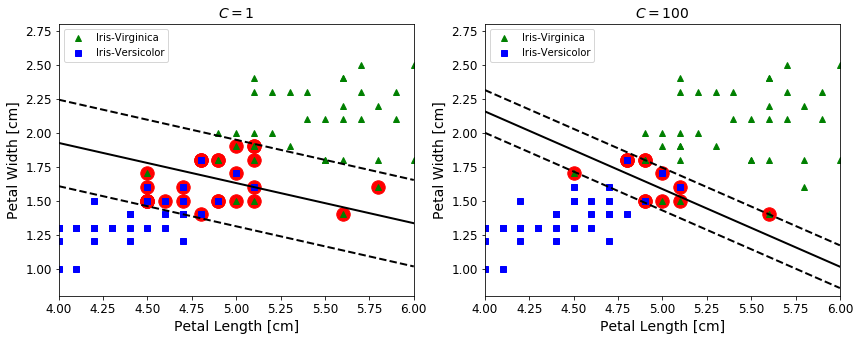

In [6]:
plt.figure(figsize=(14,5))
plt.subplot(121)
plt.plot(X[:,0][y==1],X[:,1][y==1],"g^",label="Iris-Virginica")
plt.plot(X[:,0][y==0],X[:,1][y==0],"bs",label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf1,4,6)
plt.xlabel("Petal Length [cm]")
plt.ylabel("Petal Width [cm]")
plt.legend(loc="upper left")
plt.title("$C = {}$".format(svm_clf1.C))
plt.axis([4,6,0.8,2.8])

plt.subplot(122)
plt.plot(X[:,0][y==1],X[:,1][y==1],"g^",label="Iris-Virginica")
plt.plot(X[:,0][y==0],X[:,1][y==0],"bs",label="Iris-Versicolor")
plot_svc_decision_boundary(svm_clf2,4,6)
plt.xlabel("Petal Length [cm]")
plt.ylabel("Petal Width [cm]")
plt.legend(loc="upper left")
plt.title("$C = {}$".format(svm_clf2.C))
plt.axis([4,6,0.8,2.8])

plt.show()

The SVM Linear classifier separated the two classes by minimizing the distance of the support vectors (circled in red) to the solution boundary. This particular implementation minimized the "hinge" loss function
\begin{equation}
J(\mathbf{w},b) = \frac{1}{2}\mathbf{w^Tw} + C \sum_{i=1}^{m} \textit{max}(0, 1-t^{(i)}(\mathbf{w^Tw} + b))
\end{equation}
where $\textbf{w}$ are the model weights, $b$ is the model bias, $t^{(i)}$ is -1 for negative instances and 1 for positive instances, and C is a regularization parameter that determines how wide the "street" is.

The loss is only affected by the support vectors! This means that any additional data outside of the lower and upper "street gutters" do not have any influence on model fit or predictions.

This loss also puts more weight on larger features, so the features need to be similarly scaled for SVMs to work correctly.

## Nonlinear Classification

SVMs can fit non-linear data by applying a non-linear kernel. The kernel is a function that is capabele of computing the dot product of $\phi(\textbf{a})^{T}\phi(\textbf{a})$ for a given transformation $\phi$ without actually performing the transformation.  This is computationally much cheaper.  Common kernels include
\begin{equation}
\text{Linear:   }  K(\mathbf{a},\mathbf{b}) = \mathbf{a^{T}b}
\end{equation}
\begin{equation}
\text{Polynomial:   }  K(\mathbf{a},\mathbf{b}) = (\gamma\mathbf{a^{T}b}+r)^{d} \text{   where d is order of the polynomial}
\end{equation}
\begin{equation}
\text{Gaussian Radial Basis Function:   }  K(\mathbf{a},\mathbf{b}) = \text{exp}(-\gamma||\mathbf{a-b}||^{2})
\end{equation}
\begin{equation}
\text{Sigmoid:   }  K(\mathbf{a},\mathbf{b}) = \text{tanh}(\gamma\mathbf{a^{T}b} + r)
\end{equation}

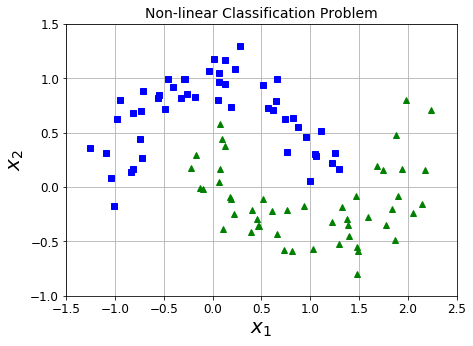

In [7]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15)

def plot_dataset(X, y, axes):
    plt.plot(X[:,0][y==0], X[:,1][y==0], "bs")
    plt.plot(X[:,0][y==1], X[:,1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20)
    
plt.figure(figsize=(7,5))
axes = [-1.5,2.5,-1,1.5]
plot_dataset(X, y, axes)
plt.title("Non-linear Classification Problem")
plt.show()
    
    
    

### Polynomial Kernel

In [8]:
from sklearn.preprocessing import PolynomialFeatures

polynomial_svm_clf = Pipeline([
    ("poly_features",PolynomialFeatures(degree=3)),
    ("scaler", StandardScaler()),
    ("svm_clf",LinearSVC(C=10, loss="hinge")),
])

polynomial_svm_clf.fit(X,y)

Pipeline(memory=None,
     steps=[('poly_features', PolynomialFeatures(degree=3, include_bias=True, interaction_only=False)), ('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='hinge', max_iter=1000, multi_class='ovr',
     penalty='l2', random_state=None, tol=0.0001, verbose=0))])

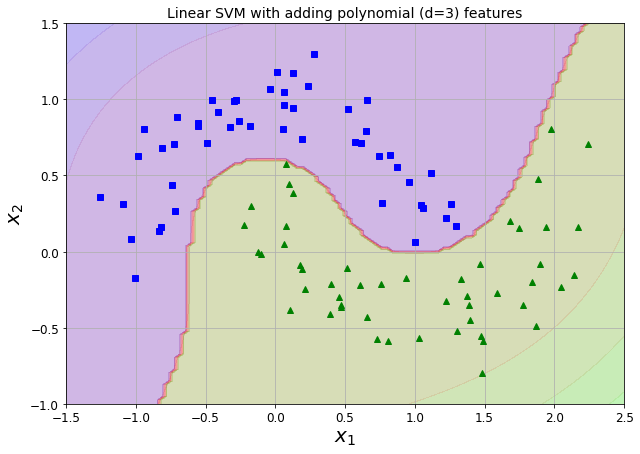

In [9]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1],100)
    x1s = np.linspace(axes[2], axes[3],100)
    x0, x1 = np.meshgrid(x0s, x1s)
    X_new = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X_new).reshape(x0.shape)
    y_decision = clf.decision_function(X_new).reshape(x0.shape)
    plt.contourf(x0,x1,y_pred, cmap="brg", alpha=0.2)
    plt.contourf(x0,x1,y_decision, cmap="brg", alpha=0.1)


plt.figure(figsize=(10,7))
plt.title("Linear SVM with adding polynomial (d=3) features")
plot_predictions(polynomial_svm_clf, axes)
plot_dataset(X,y,axes)
plt.show()

In [10]:
from sklearn.svm import SVC

# coef0 controls how much the model is influenced by high vs low degree polynomials

poly3_kernel_scm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf",SVC(kernel="poly", degree=3, coef0=1, C=5)),
])

poly3_kernel_scm_clf.fit(X,y)

poly100_kernel_scm_clf = Pipeline([
    ("scaler", StandardScaler()),
    ("svm_clf",SVC(kernel="poly", degree=10, coef0=100, C=5)),
])

poly100_kernel_scm_clf.fit(X,y)


Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svm_clf', SVC(C=5, cache_size=200, class_weight=None, coef0=100,
  decision_function_shape='ovr', degree=10, gamma='auto_deprecated',
  kernel='poly', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))])

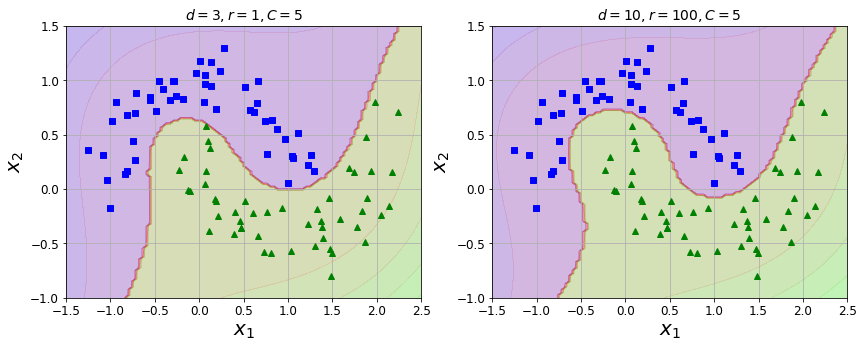

In [11]:
plt.figure(figsize=(14,5))

plt.subplot(121)
plot_predictions(poly3_kernel_scm_clf, axes)
plot_dataset(X,y, axes)
plt.title(r"$d=3, r=1, C=5$")

plt.subplot(122)
plot_predictions(poly100_kernel_scm_clf, axes)
plot_dataset(X,y, axes)
plt.title(r"$d=10, r=100, C=5$")
plt.show()

### Gaussian RBF Kernel

In [12]:
gammas = (0.1, 5,0.1,5)
Cs = (.001, 1000,1000,.001)

svm_clfs = []

for gamma, C in zip(gammas,Cs):
    rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf",SVC(kernel="rbf", gamma=gamma, C=C)),
    ])
    rbf_kernel_svm_clf.fit(X,y)
    svm_clfs.append(rbf_kernel_svm_clf)

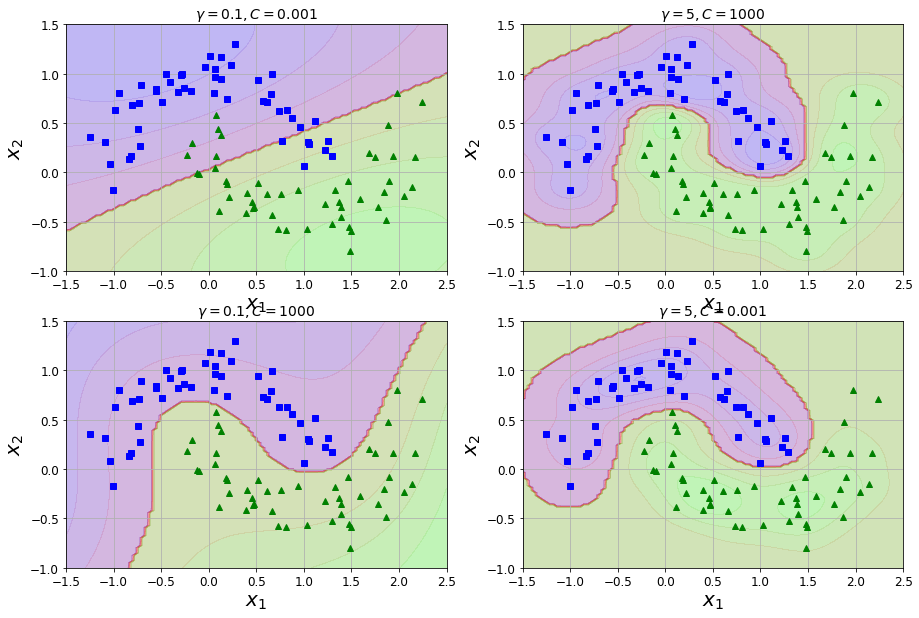

In [13]:
plt.figure(figsize=(15,10))

for i, svm_clf in enumerate(svm_clfs):
    plt.subplot(221+i)
    plot_predictions(svm_clf, axes)
    plot_dataset(X, y, axes)
    plt.title(r"$\gamma = {}, C = {}$".format(gammas[i],Cs[i]))
    
plt.show()

## SVM Regression

Support Vector Machines can also perform Regression where the general concept switches from building a "street" with the fewest instances on it to a "street" with as many possible instances on it. SVM Regression controls the width of the street by the hyperparameter $\epsilon$ where a wider street is one with a larger $\epsilon$.

In SVM Regression, the support vectors are those instances outside of the street margins, so adding more training instances within the margins does not affect the model's predictions.  Thus, the model is said to be $\textit{$\epsilon$-insensitive}$.

In [14]:
# generating linear data
m = 50
X = 2 * np.random.rand(m,1)
y = (4 + 3 * X + np.random.randn(m,1)).ravel()

In [15]:
from sklearn.svm import LinearSVR

svm_reg1 = LinearSVR(epsilon=1.5)
svm_reg2 = LinearSVR(epsilon=0.5)
svm_reg1.fit(X,y)
svm_reg2.fit(X,y)

LinearSVR(C=1.0, dual=True, epsilon=0.5, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=1000,
     random_state=None, tol=0.0001, verbose=0)

In [16]:
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

In [17]:
svm_reg1.support_ = find_support_vectors(svm_reg1, X, y)
svm_reg2.support_ = find_support_vectors(svm_reg2, X, y)

In [18]:
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100,1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors="red")
    plt.plot(X,y,"bo")
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$y$")
    plt.legend(loc="upper left", fontsize=20)
    plt.axis(axes)

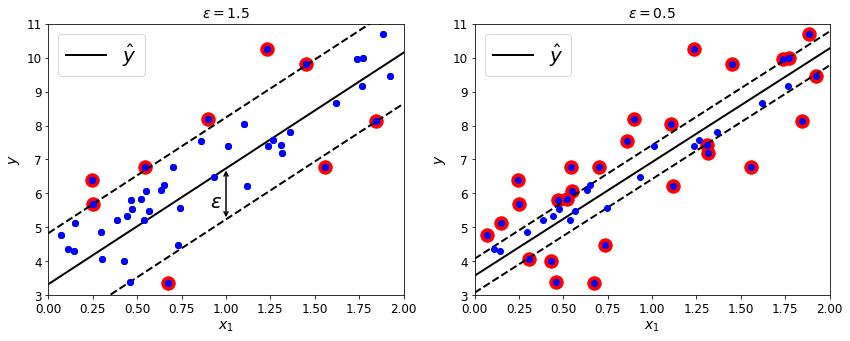

In [19]:
axes = [0,2,3,11]
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_svm_regression(svm_reg1,X,y,axes)
plt.plot(X,y,"bo")
plt.title(r"$\epsilon = {}$".format(svm_reg1.epsilon))
plt.annotate(
    '', 
    xy=(1, svm_reg1.predict([[1]])), 
    xycoords='data',
    xytext=(1, svm_reg1.predict([[1]]) - svm_reg1.epsilon),
    textcoords='data', 
    arrowprops={'arrowstyle':'<->', 'linewidth':1.5}
)
plt.text(.91,5.6,r"$\epsilon$", fontsize=20)

plt.subplot(122)
plot_svm_regression(svm_reg2,X,y,axes)
plt.title(r"$\epsilon = {}$".format(svm_reg2.epsilon))
plt.show()



In [20]:
# generating quadratic data
m = 100
X = 2 * np.random.rand(m,1) - 1
y = (0.2 + 0.1*X + 0.5*X**2 + np.random.randn(m,1)/10).ravel()

In [21]:
from sklearn.svm import SVR
svm_poly_reg1 = SVR(kernel='poly', degree=2, C=100, epsilon=0.1, gamma='auto')
svm_poly_reg2 = SVR(kernel='poly', degree=2, C=0.01, epsilon=0.1, gamma='auto')
svm_poly_reg1.fit(X,y)
svm_poly_reg2.fit(X,y)

SVR(C=0.01, cache_size=200, coef0=0.0, degree=2, epsilon=0.1, gamma='auto',
  kernel='poly', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

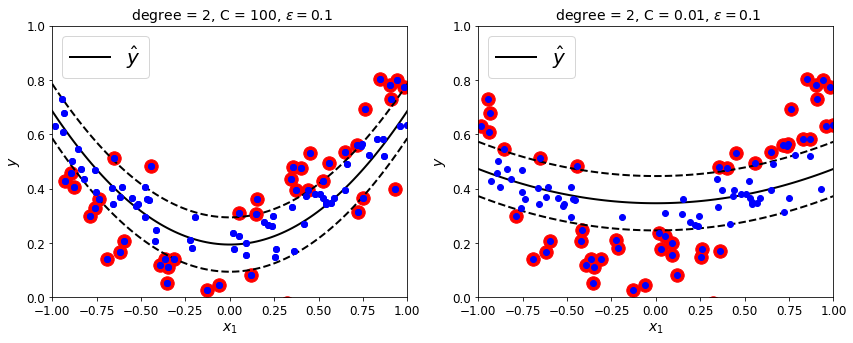

In [22]:
axes = [-1,1,0,1]
plt.figure(figsize=(14,5))
plt.subplot(121)
plot_svm_regression(svm_poly_reg1,X,y,axes)
plt.plot(X,y,"bo")
plt.title(r" degree = {}, C = {}, $\epsilon = {}$".format(svm_poly_reg1.degree, svm_poly_reg1.C, svm_poly_reg1.epsilon))

plt.subplot(122)
plot_svm_regression(svm_poly_reg2,X,y,axes)
plt.title(r" degree = {}, C = {}, $\epsilon = {}$".format(svm_poly_reg2.degree, svm_poly_reg2.C, svm_poly_reg2.epsilon))
plt.show()

## SVM Classification on MNIST data

In [23]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
X = mnist["data"] 
y = mnist["target"]

In [28]:
from sklearn.model_selection import train_test_split

X = X/255 #applying linear scaling between 0 and 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [30]:
#How well does a simple linearSVM classifier do?
lin_svm_clf = LinearSVC()
lin_svm_clf.fit(X_train, y_train)

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [31]:
from sklearn.metrics import accuracy_score

y_pred = lin_svm_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.927875

Achieved 93% accuracy on the training set for linearSVC.  How much better will the default GaussianRBF kernel do?

In [40]:
svm_rbf_clf = SVC(kernel="rbf", decision_function_shape="ovr", gamma="scale") # want One-vs-All
%time svm_rbf_clf.fit(X_train[:10000], y_train[:10000])

CPU times: user 24.8 s, sys: 232 ms, total: 25 s
Wall time: 25.3 s


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [41]:
%time y_pred = svm_rbf_clf.predict(X_train[:20000])
accuracy_score(y_train[:20000], y_pred)

CPU times: user 1min 8s, sys: 505 ms, total: 1min 8s
Wall time: 1min 9s


0.9448

Let's run a little hyperparameter search.  We will run on only 1,000 of the 54,000 total in the train set to speed up the process.

In [46]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

svm_rbf_clf = SVC(kernel="rbf", decision_function_shape="ovr")

param_distributions = {'gamma': reciprocal(.001,0.1), "C": uniform(1,10)}
rnd_search_cv = RandomizedSearchCV(svm_rbf_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] C=1.5202203200314104, gamma=0.001442141131757604 ................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] . C=1.5202203200314104, gamma=0.001442141131757604, total=   0.5s
[CV] C=1.5202203200314104, gamma=0.001442141131757604 ................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s


[CV] . C=1.5202203200314104, gamma=0.001442141131757604, total=   0.5s
[CV] C=1.5202203200314104, gamma=0.001442141131757604 ................
[CV] . C=1.5202203200314104, gamma=0.001442141131757604, total=   0.6s
[CV] C=6.432178755781418, gamma=0.01329203961856058 ..................
[CV] ... C=6.432178755781418, gamma=0.01329203961856058, total=   0.6s
[CV] C=6.432178755781418, gamma=0.01329203961856058 ..................
[CV] ... C=6.432178755781418, gamma=0.01329203961856058, total=   0.6s
[CV] C=6.432178755781418, gamma=0.01329203961856058 ..................
[CV] ... C=6.432178755781418, gamma=0.01329203961856058, total=   0.6s
[CV] C=9.075477157748782, gamma=0.0012855244605406537 ................
[CV] . C=9.075477157748782, gamma=0.0012855244605406537, total=   0.4s
[CV] C=9.075477157748782, gamma=0.0012855244605406537 ................
[CV] . C=9.075477157748782, gamma=0.0012855244605406537, total=   0.4s
[CV] C=9.075477157748782, gamma=0.0012855244605406537 ................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:   25.5s finished
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a230c3b70>, 'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a23919630>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [47]:
rnd_search_cv.best_estimator_

SVC(C=6.432178755781418, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01329203961856058,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [48]:
rnd_search_cv.best_score_

0.918

Again, we only trained on 1000 instances, so let's use the best estimator and train a larger set.

In [49]:
%time rnd_search_cv.best_estimator_.fit(X_train[:20000], y_train[:20000])

CPU times: user 1min 3s, sys: 387 ms, total: 1min 3s
Wall time: 1min 4s


SVC(C=6.432178755781418, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.01329203961856058,
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [50]:
%time y_pred = rnd_search_cv.best_estimator_.predict(X_train[:20000])
accuracy_score(y_train[:20000], y_pred)

CPU times: user 1min 40s, sys: 928 ms, total: 1min 41s
Wall time: 1min 44s


0.9997

In [51]:
%time y_pred_test = rnd_search_cv.best_estimator_.predict(X_test)
accuracy_score(y_test, y_pred_test)

CPU times: user 1min 10s, sys: 800 ms, total: 1min 11s
Wall time: 1min 14s


0.9756428571428571

Achieved 97.6% accuracy on the test set using the SVM Classifier.  Considering the training set had 99.97% accuracy, we still might be overfitting...  Other people have found that C=5 and gamma=.005 yield over 98% accuracy on the test set for MNIST data.

## SVM Regression on California Housing Dataset

In [53]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
housing

{'data': array([[   8.3252    ,   41.        ,    6.98412698, ...,    2.55555556,
           37.88      , -122.23      ],
        [   8.3014    ,   21.        ,    6.23813708, ...,    2.10984183,
           37.86      , -122.22      ],
        [   7.2574    ,   52.        ,    8.28813559, ...,    2.80225989,
           37.85      , -122.24      ],
        ...,
        [   1.7       ,   17.        ,    5.20554273, ...,    2.3256351 ,
           39.43      , -121.22      ],
        [   1.8672    ,   18.        ,    5.32951289, ...,    2.12320917,
           39.43      , -121.32      ],
        [   2.3886    ,   16.        ,    5.25471698, ...,    2.61698113,
           39.37      , -121.24      ]]),
 'target': array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894]),
 'feature_names': ['MedInc',
  'HouseAge',
  'AveRooms',
  'AveBedrms',
  'Population',
  'AveOccup',
  'Latitude',
  'Longitude'],
 'DESCR': '.. _california_housing_dataset:\n\nCalifornia Housing dataset\n--------------------

In [55]:
print(housing['DESCR'])

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block
        - HouseAge      median house age in block
        - AveRooms      average number of rooms
        - AveBedrms     average number of bedrooms
        - Population    block population
        - AveOccup      average house occupancy
        - Latitude      house block latitude
        - Longitude     house block longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
http://lib.stat.cmu.edu/datasets/

The target variable is the median house value for California districts.

This dataset was derived from the 1990 U.S. census, using one row per census
block group. A block group is the smallest geographical unit for which the U.S.
Census Bur

In [56]:
X = housing["data"]
y = housing["target"]

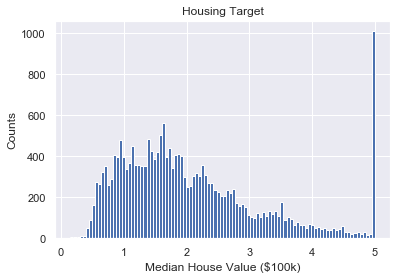

In [128]:
plt.hist(y, bins=100)
plt.xlabel("Median House Value ($100k)")
plt.ylabel("Counts")
plt.title("Housing Target")
plt.show()

In [93]:
import pandas as pd
housing_df = pd.DataFrame({'MedInc':X[:,0],
                          'HouseAge':X[:,1],
                          'AveRooms':X[:,2],
                          'AveBedrms':X[:,3],
                          'Population':X[:,4],
                          'AveOccup':X[:,5],
                          'Latitude':X[:,6],
                          'Longitude':X[:,7]})

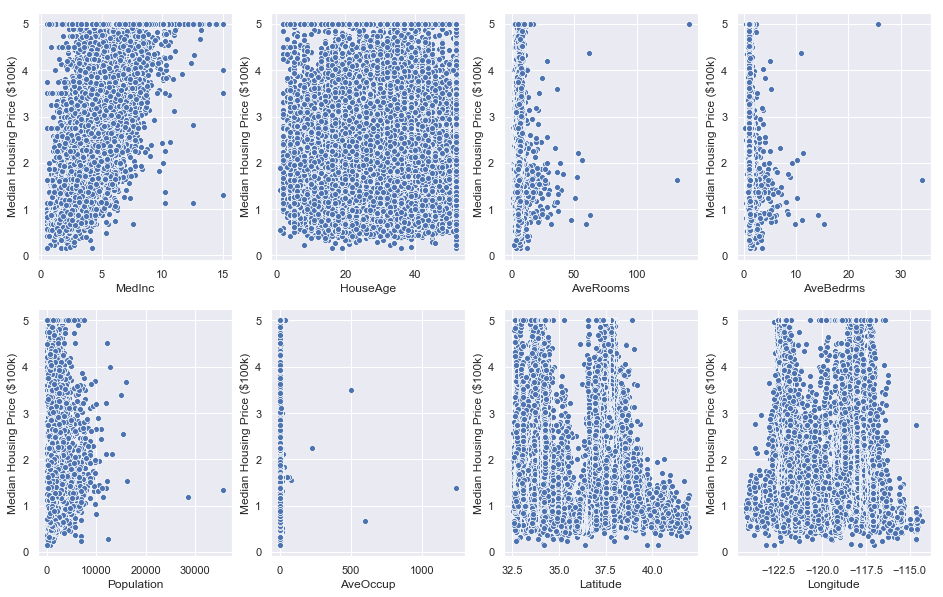

In [98]:
import seaborn as sns
sns.set()

plt.figure(figsize=(16,10))
for i, column in enumerate(housing_df.columns):
    plt.subplot(241 + i)
    sns.scatterplot(x=housing_df[column], y=y)
    plt.ylabel("Median Housing Price ($100k)")

Housing prices aren't particularly linearly related to the features, but let's start with a linearSVR anyways, just for fun.

In [103]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [108]:
from sklearn.svm import LinearSVR
lin_svr = LinearSVR(max_iter=2000)
linear_svr_pipeline = Pipeline([
    ("Scaler", StandardScaler()),
    ("lin_svr", lin_svr)
])

linear_svr_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('lin_svr', LinearSVR(C=1.0, dual=True, epsilon=0.0, fit_intercept=True,
     intercept_scaling=1.0, loss='epsilon_insensitive', max_iter=2000,
     random_state=None, tol=0.0001, verbose=0))])

In [109]:
from sklearn.metrics import mean_squared_error

y_pred = linear_svr_pipeline.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
print("LinearSVR MSE: ", mse)

LinearSVR MSE:  1.2617684634366473


How much better can the GaussianRBF kernel do?

In [121]:
from sklearn.svm import SVR

rbf_pipeline = Pipeline([
    ("scaler", StandardScaler()),
    ("rbf_svr",SVR(C=1,gamma=.01))
])

rbf_pipeline.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rbf_svr', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))])

In [122]:
y_pred = rbf_pipeline.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
print("GaussianRBF MSE: ", mse)
print("GaussianRBF RMSE: ", np.sqrt(mse))

GaussianRBF MSE:  0.4458182842868439
GaussianRBF RMSE:  0.6676962515147467


In [124]:
param_distributions = {'rbf_svr__gamma': reciprocal(.001,0.1), "rbf_svr__C": uniform(1,10)}
rbf_rnd_search_cv = RandomizedSearchCV(rbf_pipeline, param_distributions, n_iter=10, verbose=2, cv=3, n_jobs=2)
rbf_rnd_search_cv.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed:  2.2min finished


RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rbf_svr', SVR(C=1, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.01,
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=2,
          param_distributions={'rbf_svr__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a44e13a90>, 'rbf_svr__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a44e13898>},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [125]:
rbf_rnd_search_cv.best_estimator_

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rbf_svr', SVR(C=4.186177512715162, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
  gamma=0.05802083452887267, kernel='rbf', max_iter=-1, shrinking=True,
  tol=0.001, verbose=False))])

In [126]:
y_pred = rbf_rnd_search_cv.best_estimator_.predict(X_train)
mse = mean_squared_error(y_train,y_pred)
print("GaussianRBF MSE: ", mse)
print("GaussianRBF RMSE: ", np.sqrt(mse))

GaussianRBF MSE:  0.34357433535618237
GaussianRBF RMSE:  0.5861521435226372


In [127]:
y_pred_test = rbf_rnd_search_cv.best_estimator_.predict(X_test)
mse = mean_squared_error(y_test,y_pred_test)
print("GaussianRBF MSE on Test set: ", mse)
print("GaussianRBF RMSE on Test set: ", np.sqrt(mse))

GaussianRBF MSE on Test set:  0.36670152748858137
GaussianRBF RMSE on Test set:  0.6055588555116517


## What Did We Accomplish?

1. Learned the basic principles of the Support Vector Machine algorithm for both regression and classification tasks.
2. Explored how to insert non-linearity into the SVM algorithm by using polynomial and GaussianRBF kernels.
3. Applied SVM classification to the MNIST dataset.
4. Applied SVM regression on 1990 Califonia Census data to predict housing prices.